In [84]:
from datasets import load_dataset,load_from_disk
# \t is the tab character in Python
dataset = load_from_disk(r'D:\system\桌面\lcm-code\tokenizers_lcm\dataset')

In [85]:
from transformers import GPT2TokenizerFast,GPT2LMHeadModel
tokenizer=GPT2TokenizerFast.from_pretrained(r'D:\system\桌面\lcm-code\tokenizers_lcm\tokenizer_gpt100.json')
model = GPT2LMHeadModel.from_pretrained('chem_gpt100')
tokenizer.pad_token = tokenizer.eos_token

In [86]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


def tokenize(element):
    outputs = tokenizer(
        element["isosmiles"],
    )
    return outputs


tokenized_dataset = dataset.map(
    tokenize, batched=True, remove_columns=dataset['train'].column_names
)

length = [len(i) for i in tokenized_dataset['train']['input_ids']]
tokenized_dataset = tokenized_dataset.filter(lambda example: len(example['input_ids']) < 500)
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 213530
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 26692
    })
    val: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 26690
    })
})

In [87]:
from torch.utils.data.dataloader import DataLoader
from accelerate import Accelerator
tokenized_dataset.set_format("torch")
train_dataloader = DataLoader(tokenized_dataset["train"], batch_size=20, shuffle=True,collate_fn=data_collator)
eval_dataloader = DataLoader(tokenized_dataset["val"], batch_size=20,collate_fn=data_collator)
test_dataloader = DataLoader(tokenized_dataset["test"], batch_size=20,collate_fn=data_collator)
train_dataloader,eval_dataloader,test_dataloader,model=Accelerator().prepare(train_dataloader,eval_dataloader,test_dataloader,model)

In [90]:
import torch

def precise(dataloader,model):
    model.eval()
    corrects=0
    totals=0
    for step, batch in enumerate(dataloader):
        with torch.no_grad():
            outputs = model(batch["input_ids"],attention_mask=batch['attention_mask']).logits[..., :-1, :]

            labels=batch["input_ids"][..., 1:][batch['attention_mask'][:,1:].bool()].flatten()

            predict=outputs.argmax(dim=2)[batch['attention_mask'][:,1:].bool()].flatten()

            correct=(labels==predict).sum()
            total=len(labels)
        corrects+=correct
        totals+=total
    torch.cuda.empty_cache()
    return corrects/totals

In [78]:
from nltk.translate.bleu_score import sentence_bleu,corpus_bleu
def bleu_sco(dataloader,model):
    bleu_score=[]

    for step, batch in enumerate(dataloader):
        with torch.no_grad():
            outputs = model(batch["input_ids"],attention_mask=batch['attention_mask']).logits[..., :-1, :]

            labels=batch["input_ids"][..., 1:][batch['attention_mask'][:,1:].bool()]

            predict=outputs.argmax(dim=2)[batch['attention_mask'][:,1:].bool()]

            bleu=sentence_bleu([labels.cpu().numpy()],predict.cpu().numpy())

            bleu_score.append(bleu)

    torch.cuda.empty_cache()
    return sum(bleu_score)/len(bleu_score)

In [94]:
precise(test_dataloader,model)

tensor(0.8565, device='cuda:0')

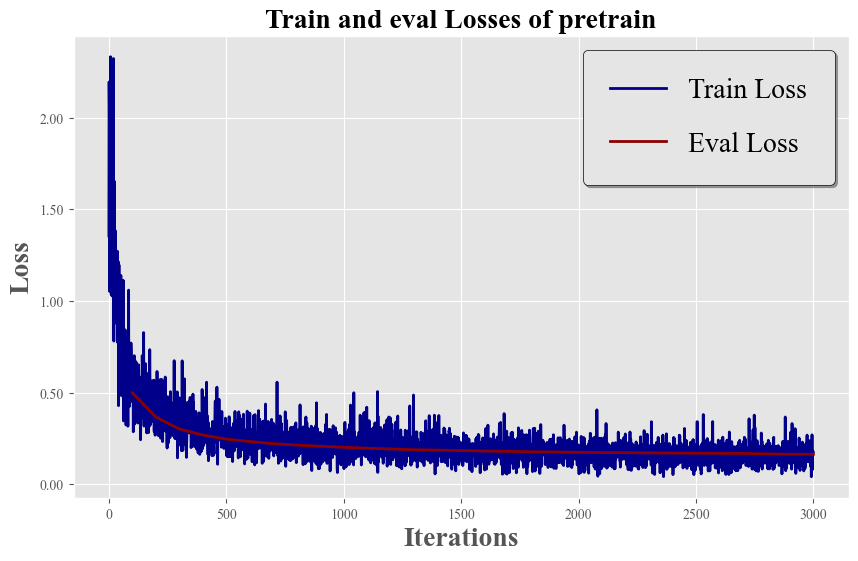

In [2]:
from matplotlib import pyplot as plt, ticker

train_losses=[1.3555352687835693,
2.1952083110809326,
2.050358772277832,
1.0526076555252075,
1.9570385217666626,
1.749480962753296,
1.9550068378448486,
2.332594633102417,
2.0423834323883057,
1.959384560585022,
1.0323516130447388,
1.2560169696807861,
1.827795386314392,
1.2941263914108276,
1.9653476476669312,
1.68954336643219,
1.9046199321746826,
1.024010419845581,
1.249901533126831,
2.3228368759155273,
1.6132313013076782,
0.7810518741607666,
1.1152199506759644,
1.0687130689620972,
1.6514630317687988,
0.8800879120826721,
1.0454343557357788,
1.3838355541229248,
1.0044041872024536,
1.0669671297073364,
0.8797283172607422,
1.1112496852874756,
1.0922291278839111,
0.960009753704071,
1.2551580667495728,
1.259128212928772,
1.271383285522461,
0.7741968631744385,
0.8368961215019226,
0.8150776028633118,
1.2143830060958862,
0.4284481108188629,
0.8871619701385498,
1.1969223022460938,
0.8779733180999756,
1.0812485218048096,
0.842397153377533,
0.8799317479133606,
0.6677556037902832,
1.0485780239105225,
0.9995101094245911,
1.1391721963882446,
0.8229696154594421,
0.5374726057052612,
0.4826192855834961,
1.1055113077163696,
0.7874466180801392,
0.8914153575897217,
0.9215196371078491,
0.7781984210014343,
0.7424217462539673,
1.112618088722229,
0.3454211354255676,
0.8353544473648071,
0.7794250845909119,
0.5734979510307312,
0.8212893605232239,
0.475807249546051,
0.42019742727279663,
0.842889130115509,
0.6811922788619995,
0.7927594184875488,
0.7888831496238708,
0.3232433497905731,
0.7159820199012756,
0.7513467073440552,
0.7283042073249817,
0.7143343091011047,
0.6450619101524353,
0.5220181345939636,
0.5664126873016357,
0.31665900349617004,
0.6086170077323914,
0.4579664170742035,
1.059234380722046,
0.4840127229690552,
0.44231969118118286,
0.6575450897216797,
0.42543482780456543,
0.7501212954521179,
0.5077845454216003,
0.5799642205238342,
0.5178674459457397,
0.4968409836292267,
0.7705945372581482,
0.7218027710914612,
0.4823598563671112,
0.49227362871170044,
0.4974794387817383,
0.6491729021072388,
0.45487654209136963,
0.5389258861541748,
0.4471345543861389,
0.6227586269378662,
0.2861112356185913,
0.4808715879917145,
0.6307724714279175,
0.36141273379325867,
0.7012565732002258,
0.32743486762046814,
0.5732260942459106,
0.588837206363678,
0.6727834343910217,
0.6704365611076355,
0.35654497146606445,
0.4422265887260437,
0.33845070004463196,
0.6636576056480408,
0.648980438709259,
0.5833184719085693,
0.5758821368217468,
0.5105347037315369,
0.4003560245037079,
0.5913689732551575,
0.33379778265953064,
0.49302977323532104,
0.6518948078155518,
0.6207325458526611,
0.40504908561706543,
0.5875018835067749,
0.578867495059967,
0.5112856030464172,
0.4613634943962097,
0.44971710443496704,
0.40953734517097473,
0.24255850911140442,
0.35052675008773804,
0.35796546936035156,
0.43631523847579956,
0.497980535030365,
0.5500841736793518,
0.42965880036354065,
0.702242910861969,
0.5828773975372314,
0.5465036630630493,
0.5931968688964844,
0.527129590511322,
0.39315474033355713,
0.8273035287857056,
0.46761247515678406,
0.31715691089630127,
0.5105262994766235,
0.43846866488456726,
0.45409688353538513,
0.5202495455741882,
0.4097239673137665,
0.6578977704048157,
0.48774123191833496,
0.46047812700271606,
0.46801093220710754,
0.5428370237350464,
0.2798963487148285,
0.43543556332588196,
0.3509027659893036,
0.45402222871780396,
0.39212024211883545,
0.604310929775238,
0.48958203196525574,
0.5053571462631226,
0.2817968428134918,
0.4830677807331085,
0.31388959288597107,
0.4049820601940155,
0.5114243030548096,
0.734343409538269,
0.5560774207115173,
0.4063749313354492,
0.3239155411720276,
0.48231738805770874,
0.3877265751361847,
0.47670572996139526,
0.45675531029701233,
0.452506422996521,
0.3909561038017273,
0.45176348090171814,
0.5647665858268738,
0.4059986174106598,
0.4737342298030853,
0.47660017013549805,
0.3404296338558197,
0.4705647826194763,
0.3539484739303589,
0.5675894021987915,
0.28764602541923523,
0.537775456905365,
0.42412859201431274,
0.36806705594062805,
0.26741743087768555,
0.49024611711502075,
0.5266966223716736,
0.2824428677558899,
0.41414788365364075,
0.496902734041214,
0.537634015083313,
0.40235617756843567,
0.6151643991470337,
0.4660438001155853,
0.44989678263664246,
0.5214083194732666,
0.29904597997665405,
0.2659434378147125,
0.26956310868263245,
0.3356828987598419,
0.3392471373081207,
0.44568249583244324,
0.3106856346130371,
0.4257746636867523,
0.43912041187286377,
0.2625477910041809,
0.5717610120773315,
0.41776397824287415,
0.25087329745292664,
0.40284040570259094,
0.3759077191352844,
0.35986873507499695,
0.2720429003238678,
0.5710201263427734,
0.384263813495636,
0.371425986289978,
0.23273470997810364,
0.39010611176490784,
0.38551971316337585,
0.2914700508117676,
0.4888814389705658,
0.42275846004486084,
0.33724409341812134,
0.46016693115234375,
0.5030659437179565,
0.4964623749256134,
0.42531779408454895,
0.5849456191062927,
0.3016567826271057,
0.3554178774356842,
0.2875383496284485,
0.3582915961742401,
0.44590699672698975,
0.41393494606018066,
0.23793670535087585,
0.19740551710128784,
0.33967339992523193,
0.47768041491508484,
0.28067392110824585,
0.3445969223976135,
0.22486145794391632,
0.36890390515327454,
0.3203446567058563,
0.43947386741638184,
0.36638545989990234,
0.321798175573349,
0.41642025113105774,
0.2540215849876404,
0.4467223286628723,
0.5048354268074036,
0.3425579369068146,
0.2816811203956604,
0.38229602575302124,
0.44598388671875,
0.4274739921092987,
0.29248538613319397,
0.3222891688346863,
0.2810288369655609,
0.34051820635795593,
0.2784072756767273,
0.2651139497756958,
0.38173243403434753,
0.3308984935283661,
0.2968585789203644,
0.39281967282295227,
0.67411869764328,
0.25306737422943115,
0.34994563460350037,
0.2617107033729553,
0.3204978108406067,
0.24817869067192078,
0.43439754843711853,
0.4380365312099457,
0.40170374512672424,
0.24968169629573822,
0.3890635669231415,
0.26262030005455017,
0.24616728723049164,
0.5041263699531555,
0.14369994401931763,
0.3688066303730011,
0.3654211163520813,
0.3877628743648529,
0.3047657012939453,
0.21249760687351227,
0.3309163451194763,
0.2896233797073364,
0.4715386927127838,
0.4130156636238098,
0.43034085631370544,
0.3299359679222107,
0.3430711030960083,
0.36970680952072144,
0.3101595342159271,
0.37636125087738037,
0.34821027517318726,
0.1825520396232605,
0.2652859091758728,
0.3522510826587677,
0.673234760761261,
0.43672099709510803,
0.32354027032852173,
0.18482233583927155,
0.3018472194671631,
0.4187092185020447,
0.3021997809410095,
0.28746381402015686,
0.3391285538673401,
0.37275782227516174,
0.5750804543495178,
0.2964799404144287,
0.30277228355407715,
0.24284105002880096,
0.21380497515201569,
0.3003455400466919,
0.21644799411296844,
0.39729613065719604,
0.14654652774333954,
0.2182280570268631,
0.24771347641944885,
0.33024388551712036,
0.4463588297367096,
0.36762624979019165,
0.2861117422580719,
0.31133416295051575,
0.44611161947250366,
0.2972604036331177,
0.36426103115081787,
0.34723377227783203,
0.27974945306777954,
0.4417993128299713,
0.45480817556381226,
0.4248533248901367,
0.47353509068489075,
0.36607876420021057,
0.34959903359413147,
0.4485117793083191,
0.19989420473575592,
0.21245062351226807,
0.20495446026325226,
0.2071560174226761,
0.32702258229255676,
0.27993083000183105,
0.23250028491020203,
0.20863980054855347,
0.4912554919719696,
0.3176133632659912,
0.44698411226272583,
0.28733545541763306,
0.3511951267719269,
0.25584128499031067,
0.20909833908081055,
0.2055608034133911,
0.22740328311920166,
0.3519473969936371,
0.28587597608566284,
0.3563416600227356,
0.39768898487091064,
0.3313186466693878,
0.3657609522342682,
0.19230243563652039,
0.284792959690094,
0.3316443860530853,
0.2540077865123749,
0.300539493560791,
0.31645894050598145,
0.2476007640361786,
0.1710287630558014,
0.3139108121395111,
0.2303105741739273,
0.20688551664352417,
0.38973408937454224,
0.3530988097190857,
0.2946474850177765,
0.16282296180725098,
0.3503729999065399,
0.2644434869289398,
0.3341743052005768,
0.27024200558662415,
0.17717911303043365,
0.3386785686016083,
0.18067136406898499,
0.36810848116874695,
0.36428824067115784,
0.5169315934181213,
0.4311560094356537,
0.1936326026916504,
0.33469220995903015,
0.3091329038143158,
0.2859148383140564,
0.21087661385536194,
0.33404210209846497,
0.26321524381637573,
0.3783695697784424,
0.4721687436103821,
0.363456666469574,
0.25002625584602356,
0.3315896689891815,
0.31891605257987976,
0.3137173354625702,
0.2536109685897827,
0.2662925720214844,
0.27996960282325745,
0.5568326115608215,
0.2214868813753128,
0.3762180507183075,
0.30581405758857727,
0.3270203471183777,
0.22065038979053497,
0.16205033659934998,
0.33676332235336304,
0.1281106323003769,
0.2634497880935669,
0.22761844098567963,
0.18711663782596588,
0.20761741697788239,
0.1949281096458435,
0.17970195412635803,
0.17990125715732574,
0.240223690867424,
0.20297369360923767,
0.20186272263526917,
0.24805814027786255,
0.20969155430793762,
0.3047221302986145,
0.2845064103603363,
0.1556587666273117,
0.2944263219833374,
0.34219658374786377,
0.33095794916152954,
0.2700360119342804,
0.221047043800354,
0.15733976662158966,
0.2947724461555481,
0.20231769979000092,
0.16543644666671753,
0.3380497992038727,
0.25421959161758423,
0.3439396023750305,
0.4136497378349304,
0.45419883728027344,
0.3389819860458374,
0.3471701145172119,
0.24498780071735382,
0.386727899312973,
0.2574566602706909,
0.2991938591003418,
0.5296348333358765,
0.22391273081302643,
0.4158007800579071,
0.10919098556041718,
0.2674514353275299,
0.3008030951023102,
0.4271993637084961,
0.2650233209133148,
0.282241553068161,
0.4635007679462433,
0.24206417798995972,
0.33966130018234253,
0.37349462509155273,
0.24273478984832764,
0.3530852496623993,
0.2534286677837372,
0.2942417562007904,
0.3309699296951294,
0.2961008846759796,
0.20196367800235748,
0.2291794717311859,
0.3969170153141022,
0.23788630962371826,
0.2954409420490265,
0.2549848258495331,
0.25314128398895264,
0.20939593017101288,
0.28021565079689026,
0.2614568769931793,
0.2592809200286865,
0.19498392939567566,
0.26008114218711853,
0.31540215015411377,
0.31653833389282227,
0.3090313971042633,
0.20152783393859863,
0.36066240072250366,
0.250642865896225,
0.27611634135246277,
0.25759345293045044,
0.234501451253891,
0.15609724819660187,
0.16720019280910492,
0.22356075048446655,
0.2724663019180298,
0.14960333704948425,
0.3273801803588867,
0.20014457404613495,
0.2938297688961029,
0.2415408045053482,
0.1954711377620697,
0.2681272625923157,
0.3683755099773407,
0.15066556632518768,
0.1785276085138321,
0.2912491261959076,
0.2815059721469879,
0.3127341866493225,
0.21284091472625732,
0.15031608939170837,
0.22365394234657288,
0.1923763006925583,
0.19483591616153717,
0.2155100256204605,
0.18932177126407623,
0.2133585661649704,
0.22386573255062103,
0.12389074265956879,
0.27917662262916565,
0.17783144116401672,
0.2498788982629776,
0.28735315799713135,
0.33373093605041504,
0.2470117062330246,
0.1827622652053833,
0.26783478260040283,
0.2980194687843323,
0.39698177576065063,
0.267152339220047,
0.28830134868621826,
0.24847465753555298,
0.3224554657936096,
0.30036795139312744,
0.2807074785232544,
0.28913864493370056,
0.20600494742393494,
0.34819865226745605,
0.27461087703704834,
0.3092193603515625,
0.21747632324695587,
0.2872268259525299,
0.1431802660226822,
0.25140252709388733,
0.39494067430496216,
0.3273870646953583,
0.3016601800918579,
0.1887458860874176,
0.37475234270095825,
0.17073822021484375,
0.2861323356628418,
0.15031351149082184,
0.3238334357738495,
0.25427812337875366,
0.24222484230995178,
0.289470374584198,
0.3251588046550751,
0.3549192249774933,
0.19121721386909485,
0.3426108956336975,
0.31185224652290344,
0.24117602407932281,
0.2435382455587387,
0.18841668963432312,
0.38203585147857666,
0.23692169785499573,
0.2554458975791931,
0.28984397649765015,
0.2993899881839752,
0.11075771600008011,
0.17163364589214325,
0.20662060379981995,
0.2928715646266937,
0.2547605633735657,
0.2557602822780609,
0.20256738364696503,
0.2468288540840149,
0.13565167784690857,
0.2600426971912384,
0.16604936122894287,
0.39874500036239624,
0.20575402677059174,
0.16214530169963837,
0.14275094866752625,
0.21506565809249878,
0.16406738758087158,
0.2218266725540161,
0.21854589879512787,
0.1727733016014099,
0.2703591585159302,
0.19026702642440796,
0.3881726562976837,
0.28085803985595703,
0.2681419253349304,
0.16337764263153076,
0.3001765012741089,
0.1948401927947998,
0.26758715510368347,
0.2209693193435669,
0.23203828930854797,
0.24068936705589294,
0.12252602726221085,
0.19894076883792877,
0.29115214943885803,
0.18567781150341034,
0.24730709195137024,
0.19659237563610077,
0.2532602846622467,
0.3752693831920624,
0.2372274249792099,
0.33342525362968445,
0.29179662466049194,
0.10537739098072052,
0.37973108887672424,
0.2827654778957367,
0.11698316782712936,
0.2587569057941437,
0.22870001196861267,
0.12138553708791733,
0.24671649932861328,
0.1173846498131752,
0.25018712878227234,
0.19208544492721558,
0.2521379888057709,
0.1961827427148819,
0.2812064588069916,
0.25879427790641785,
0.244254931807518,
0.40163442492485046,
0.2438320517539978,
0.19660641252994537,
0.2091084122657776,
0.2291543185710907,
0.35568198561668396,
0.30927523970603943,
0.26465457677841187,
0.1974402815103531,
0.2401793897151947,
0.30927956104278564,
0.24435776472091675,
0.29743170738220215,
0.3163661062717438,
0.2650713324546814,
0.25248807668685913,
0.11416283249855042,
0.29173916578292847,
0.34345901012420654,
0.2925967872142792,
0.2435106486082077,
0.3228084444999695,
0.12463393062353134,
0.23057541251182556,
0.19140438735485077,
0.18954253196716309,
0.2838798463344574,
0.15951035916805267,
0.35180264711380005,
0.3052007555961609,
0.4376815855503082,
0.16896319389343262,
0.2075759768486023,
0.2314671277999878,
0.15997235476970673,
0.15191534161567688,
0.15853077173233032,
0.16547603905200958,
0.21169984340667725,
0.2491888552904129,
0.3297480344772339,
0.34293991327285767,
0.2270749807357788,
0.22161753475666046,
0.14105908572673798,
0.3131563365459442,
0.19930477440357208,
0.21827739477157593,
0.2704262435436249,
0.20144808292388916,
0.18115946650505066,
0.21229907870292664,
0.22461332380771637,
0.32048872113227844,
0.33441704511642456,
0.23891283571720123,
0.35381534695625305,
0.2642432153224945,
0.24665886163711548,
0.27392569184303284,
0.2014283388853073,
0.19562311470508575,
0.18523035943508148,
0.33331748843193054,
0.16390982270240784,
0.1544671356678009,
0.251643568277359,
0.3201952278614044,
0.2765023410320282,
0.18011054396629333,
0.17570634186267853,
0.26701784133911133,
0.28685322403907776,
0.17294354736804962,
0.2984621524810791,
0.3050013482570648,
0.2502475678920746,
0.3046276271343231,
0.2971685826778412,
0.5569196939468384,
0.3088105320930481,
0.28830504417419434,
0.15711213648319244,
0.17132677137851715,
0.22846536338329315,
0.11401981860399246,
0.24442051351070404,
0.22638048231601715,
0.17969220876693726,
0.34645095467567444,
0.1674319952726364,
0.28561925888061523,
0.37306156754493713,
0.23120331764221191,
0.21752390265464783,
0.12631529569625854,
0.24478565156459808,
0.33207595348358154,
0.3038821518421173,
0.14596538245677948,
0.1407613605260849,
0.21152377128601074,
0.14267930388450623,
0.23715099692344666,
0.16733421385288239,
0.23649568855762482,
0.22664617002010345,
0.16293136775493622,
0.24140287935733795,
0.2684229612350464,
0.16733253002166748,
0.17803680896759033,
0.2868732810020447,
0.2622028589248657,
0.39519116282463074,
0.24690286815166473,
0.09778372943401337,
0.2932133376598358,
0.17463251948356628,
0.3382163643836975,
0.3478376567363739,
0.20163795351982117,
0.19808965921401978,
0.26051443815231323,
0.2044450044631958,
0.22797751426696777,
0.1405695676803589,
0.17748934030532837,
0.2091599851846695,
0.16403387486934662,
0.2535913586616516,
0.13537228107452393,
0.23055210709571838,
0.28786247968673706,
0.1293615996837616,
0.15303611755371094,
0.23140430450439453,
0.17334634065628052,
0.31035757064819336,
0.1307319700717926,
0.24802489578723907,
0.300198495388031,
0.29913029074668884,
0.3100986182689667,
0.22403988242149353,
0.28686198592185974,
0.28725048899650574,
0.13905271887779236,
0.25197166204452515,
0.15859560668468475,
0.2189064472913742,
0.16929040849208832,
0.24598205089569092,
0.2535077929496765,
0.317988783121109,
0.15490838885307312,
0.17715483903884888,
0.16209352016448975,
0.30527934432029724,
0.3348771631717682,
0.30392125248908997,
0.11777177453041077,
0.1779009997844696,
0.23030132055282593,
0.20194527506828308,
0.1918846070766449,
0.22217470407485962,
0.23375852406024933,
0.2959628999233246,
0.26894277334213257,
0.15334367752075195,
0.21059288084506989,
0.2650086283683777,
0.22369542717933655,
0.30109626054763794,
0.26707538962364197,
0.1656293421983719,
0.432814359664917,
0.17000509798526764,
0.2748054563999176,
0.24129720032215118,
0.3045184314250946,
0.2441428154706955,
0.281983345746994,
0.2579655647277832,
0.2558830678462982,
0.22080673277378082,
0.24655182659626007,
0.23886071145534515,
0.2661608159542084,
0.10673671960830688,
0.3130049705505371,
0.2158503234386444,
0.17269739508628845,
0.3078124523162842,
0.15546345710754395,
0.24247045814990997,
0.2161749005317688,
0.2772206664085388,
0.1112934798002243,
0.14753268659114838,
0.3052164912223816,
0.3668249249458313,
0.15638196468353271,
0.19134646654129028,
0.12243964523077011,
0.3355666697025299,
0.12738122045993805,
0.2961704134941101,
0.2778497636318207,
0.2211899608373642,
0.27431419491767883,
0.30352118611335754,
0.26644667983055115,
0.2693231403827667,
0.22642986476421356,
0.161672905087471,
0.22584915161132812,
0.16388195753097534,
0.12369673699140549,
0.17917567491531372,
0.20637229084968567,
0.2256084382534027,
0.2543986141681671,
0.13002179563045502,
0.31680741906166077,
0.12170358002185822,
0.07469727843999863,
0.25086212158203125,
0.2169066071510315,
0.26929783821105957,
0.2734443247318268,
0.2360350787639618,
0.30431610345840454,
0.23069702088832855,
0.2359057366847992,
0.14773108065128326,
0.2107493132352829,
0.3029177486896515,
0.12494015693664551,
0.18614202737808228,
0.24771404266357422,
0.2593049705028534,
0.1168503686785698,
0.3194175958633423,
0.22144195437431335,
0.2175978124141693,
0.4443681240081787,
0.12965703010559082,
0.10735748708248138,
0.3050549626350403,
0.29042285680770874,
0.2567756474018097,
0.12374642491340637,
0.2416573315858841,
0.08578526228666306,
0.1763419210910797,
0.0845268964767456,
0.2675803303718567,
0.08563792705535889,
0.16919538378715515,
0.20684736967086792,
0.20824681222438812,
0.28320038318634033,
0.2728774845600128,
0.27424681186676025,
0.10909947752952576,
0.13659624755382538,
0.22855645418167114,
0.2397536337375641,
0.24626964330673218,
0.2303781509399414,
0.2304256409406662,
0.23266735672950745,
0.12268046289682388,
0.27425405383110046,
0.21077048778533936,
0.18294528126716614,
0.23577505350112915,
0.23794850707054138,
0.27665528655052185,
0.17679408192634583,
0.22427576780319214,
0.20599594712257385,
0.2628629207611084,
0.13032853603363037,
0.32690533995628357,
0.2226892113685608,
0.25069841742515564,
0.20791055262088776,
0.38076865673065186,
0.14555610716342926,
0.11366502195596695,
0.15785661339759827,
0.23001256585121155,
0.13173697888851166,
0.245382159948349,
0.1469731628894806,
0.19219283759593964,
0.11882424354553223,
0.2579789459705353,
0.2994259297847748,
0.2886280417442322,
0.14018814265727997,
0.21553178131580353,
0.07232022285461426,
0.2976438105106354,
0.2382681518793106,
0.16175587475299835,
0.18380045890808105,
0.23520256578922272,
0.15207020938396454,
0.2491571605205536,
0.2116309553384781,
0.24159950017929077,
0.1453673094511032,
0.19106248021125793,
0.24805805087089539,
0.31938639283180237,
0.18393222987651825,
0.24726085364818573,
0.16823694109916687,
0.21093256771564484,
0.16577404737472534,
0.2528543472290039,
0.278225302696228,
0.17071856558322906,
0.18498872220516205,
0.307711124420166,
0.21059051156044006,
0.16411533951759338,
0.18526117503643036,
0.27140694856643677,
0.28408074378967285,
0.232859268784523,
0.08447197079658508,
0.06376241892576218,
0.2597804069519043,
0.2138030230998993,
0.15976731479167938,
0.16560660302639008,
0.2271253913640976,
0.2389022558927536,
0.24060507118701935,
0.22834256291389465,
0.18189451098442078,
0.17504160106182098,
0.26714441180229187,
0.23664037883281708,
0.25112876296043396,
0.13182388246059418,
0.10574785619974136,
0.19229477643966675,
0.2163728028535843,
0.12735311686992645,
0.2615564465522766,
0.14835521578788757,
0.20765136182308197,
0.20234829187393188,
0.16662980616092682,
0.1398899406194687,
0.12171664834022522,
0.20034246146678925,
0.1685214638710022,
0.08487618714570999,
0.20663811266422272,
0.13441093266010284,
0.10797794163227081,
0.33738383650779724,
0.1681947559118271,
0.2594206929206848,
0.22852183878421783,
0.18850292265415192,
0.09436629712581635,
0.23101039230823517,
0.14336778223514557,
0.2146092802286148,
0.21431386470794678,
0.14073508977890015,
0.27855437994003296,
0.2858794331550598,
0.12084219604730606,
0.1670611947774887,
0.17520520091056824,
0.3009364902973175,
0.20669907331466675,
0.10705411434173584,
0.22293208539485931,
0.3262108266353607,
0.19554099440574646,
0.2569842040538788,
0.1970359832048416,
0.43228471279144287,
0.12125284224748611,
0.19545385241508484,
0.3110470175743103,
0.16988082230091095,
0.2822168171405792,
0.26982399821281433,
0.1636299341917038,
0.19381855428218842,
0.2314649373292923,
0.3069232702255249,
0.17738109827041626,
0.23657409846782684,
0.10521858185529709,
0.49927765130996704,
0.1868995875120163,
0.2863222062587738,
0.23420488834381104,
0.23953081667423248,
0.25784626603126526,
0.19895373284816742,
0.22166624665260315,
0.13973145186901093,
0.18550796806812286,
0.1720626950263977,
0.21969711780548096,
0.17799611389636993,
0.21942144632339478,
0.18479663133621216,
0.21851979196071625,
0.1493709534406662,
0.2488405853509903,
0.26152873039245605,
0.1662210375070572,
0.2168378084897995,
0.21919876337051392,
0.2834325134754181,
0.16437073051929474,
0.1812775731086731,
0.24673950672149658,
0.1529163420200348,
0.37672746181488037,
0.24195975065231323,
0.26322031021118164,
0.30838584899902344,
0.1752675622701645,
0.10502190887928009,
0.34525561332702637,
0.2985653281211853,
0.18446120619773865,
0.2163005918264389,
0.1940409243106842,
0.15773934125900269,
0.2186831384897232,
0.28899332880973816,
0.20004047453403473,
0.21826843917369843,
0.3900498151779175,
0.2331487387418747,
0.23992016911506653,
0.2097436487674713,
0.24360613524913788,
0.39092424511909485,
0.23093068599700928,
0.22479146718978882,
0.14931818842887878,
0.1744697093963623,
0.20482133328914642,
0.23180581629276276,
0.4202481508255005,
0.21450072526931763,
0.23054571449756622,
0.2946518659591675,
0.2069166600704193,
0.24718759953975677,
0.23582950234413147,
0.2448931187391281,
0.20448122918605804,
0.13188792765140533,
0.34707093238830566,
0.27416709065437317,
0.2546102702617645,
0.2798106372356415,
0.24423719942569733,
0.12951475381851196,
0.27760955691337585,
0.11668054014444351,
0.13658246397972107,
0.22898012399673462,
0.2034817785024643,
0.13389059901237488,
0.257571816444397,
0.2500055432319641,
0.30236735939979553,
0.13547572493553162,
0.18736080825328827,
0.20706994831562042,
0.13163331151008606,
0.30947044491767883,
0.15299053490161896,
0.1646103411912918,
0.1600404977798462,
0.21952131390571594,
0.11160055547952652,
0.3348987102508545,
0.11881577223539352,
0.12152759730815887,
0.14654740691184998,
0.18916574120521545,
0.3158130347728729,
0.32620149850845337,
0.1352231353521347,
0.10224682092666626,
0.26263266801834106,
0.2484523206949234,
0.5055843591690063,
0.0643753856420517,
0.37153008580207825,
0.12060758471488953,
0.15605148673057556,
0.23174673318862915,
0.19979771971702576,
0.23236370086669922,
0.26239264011383057,
0.22945387661457062,
0.1660981923341751,
0.19344094395637512,
0.22340364754199982,
0.3100661635398865,
0.2003393918275833,
0.3031006157398224,
0.24224421381950378,
0.14801065623760223,
0.15429122745990753,
0.19139130413532257,
0.21702980995178223,
0.21766336262226105,
0.20920714735984802,
0.14387547969818115,
0.11425222456455231,
0.13917487859725952,
0.22189803421497345,
0.2156965285539627,
0.15212254226207733,
0.2509828805923462,
0.3234480619430542,
0.18799041211605072,
0.23692111670970917,
0.2366110384464264,
0.2564438283443451,
0.19825837016105652,
0.1570984125137329,
0.2540195882320404,
0.17780716717243195,
0.20823998749256134,
0.35216638445854187,
0.0985710620880127,
0.1973111927509308,
0.28588399291038513,
0.15497572720050812,
0.19049786031246185,
0.16984359920024872,
0.14166519045829773,
0.36704540252685547,
0.19627299904823303,
0.1876782327890396,
0.14936712384223938,
0.31962791085243225,
0.2203463912010193,
0.36262670159339905,
0.11265686899423599,
0.10797323286533356,
0.16716724634170532,
0.19848500192165375,
0.1975337117910385,
0.23021197319030762,
0.3272068202495575,
0.1368533819913864,
0.22091546654701233,
0.14909465610980988,
0.13397476077079773,
0.2339421659708023,
0.17094829678535461,
0.23897267878055573,
0.23138834536075592,
0.24906112253665924,
0.16049815714359283,
0.19956709444522858,
0.14858539402484894,
0.24021071195602417,
0.2974919378757477,
0.23703472316265106,
0.2821968197822571,
0.3390592038631439,
0.16884225606918335,
0.18483974039554596,
0.1011442020535469,
0.31848233938217163,
0.16848477721214294,
0.17461398243904114,
0.20708681643009186,
0.37257203459739685,
0.16401991248130798,
0.21216022968292236,
0.2729939818382263,
0.15901105105876923,
0.21745328605175018,
0.09390630573034286,
0.1429334580898285,
0.21232475340366364,
0.21162599325180054,
0.16318251192569733,
0.23063917458057404,
0.2419716864824295,
0.2963157594203949,
0.24217340350151062,
0.22211366891860962,
0.12580274045467377,
0.08385392278432846,
0.20428678393363953,
0.13986912369728088,
0.25648233294487,
0.2004471868276596,
0.2499646246433258,
0.18668296933174133,
0.19314737617969513,
0.1886442005634308,
0.2377147227525711,
0.13860341906547546,
0.2085549235343933,
0.1505037099123001,
0.1523207575082779,
0.10141760855913162,
0.29494091868400574,
0.10336463898420334,
0.1634819507598877,
0.1890389770269394,
0.11828538775444031,
0.21556249260902405,
0.22187216579914093,
0.16832007467746735,
0.20653364062309265,
0.18753956258296967,
0.19771653413772583,
0.19164323806762695,
0.2178163230419159,
0.2923012971878052,
0.18982432782649994,
0.2143964022397995,
0.17245522141456604,
0.166461780667305,
0.15318545699119568,
0.4271918535232544,
0.16333480179309845,
0.23063161969184875,
0.2382492572069168,
0.24028199911117554,
0.10386563092470169,
0.25768184661865234,
0.10931827872991562,
0.22692684829235077,
0.24098418653011322,
0.13191813230514526,
0.22411206364631653,
0.18173851072788239,
0.15094555914402008,
0.12580376863479614,
0.2918464243412018,
0.48694664239883423,
0.14127029478549957,
0.23800556361675262,
0.19909308850765228,
0.28709766268730164,
0.15494434535503387,
0.18896691501140594,
0.26300451159477234,
0.16652916371822357,
0.13233335316181183,
0.2098076343536377,
0.12707369029521942,
0.1829647719860077,
0.2183699607849121,
0.2861710786819458,
0.2147829830646515,
0.09341467916965485,
0.2393570989370346,
0.24496281147003174,
0.13241995871067047,
0.22269713878631592,
0.2291925549507141,
0.19675229489803314,
0.22767743468284607,
0.1302531361579895,
0.15263599157333374,
0.2163541465997696,
0.13466618955135345,
0.16841259598731995,
0.13932622969150543,
0.13075247406959534,
0.18940535187721252,
0.28346166014671326,
0.2660970687866211,
0.18565601110458374,
0.21422122418880463,
0.12120700627565384,
0.27420470118522644,
0.15020807087421417,
0.24534761905670166,
0.25962144136428833,
0.18101458251476288,
0.13594526052474976,
0.2696413993835449,
0.12669573724269867,
0.10140528529882431,
0.2121322602033615,
0.2479952871799469,
0.26710081100463867,
0.2842610776424408,
0.14920611679553986,
0.23522502183914185,
0.346258282661438,
0.23624081909656525,
0.1373714953660965,
0.1796942800283432,
0.20283055305480957,
0.22482401132583618,
0.28890955448150635,
0.22246964275836945,
0.1886875480413437,
0.23676714301109314,
0.14422936737537384,
0.12937884032726288,
0.14151135087013245,
0.21010136604309082,
0.2735327482223511,
0.3740736246109009,
0.1858907788991928,
0.2203250676393509,
0.24219754338264465,
0.20961976051330566,
0.11602655053138733,
0.11785493791103363,
0.15004178881645203,
0.14672324061393738,
0.22600139677524567,
0.24958157539367676,
0.17316648364067078,
0.1703689992427826,
0.2950902581214905,
0.16516201198101044,
0.2980397045612335,
0.12402285635471344,
0.15843120217323303,
0.26348188519477844,
0.1779026985168457,
0.2174667865037918,
0.22777923941612244,
0.3768051266670227,
0.26218459010124207,
0.16780848801136017,
0.056197650730609894,
0.2320484220981598,
0.15186423063278198,
0.17584651708602905,
0.1481289267539978,
0.3000553250312805,
0.26852408051490784,
0.18930698931217194,
0.16444894671440125,
0.1011037826538086,
0.2079518586397171,
0.3390181362628937,
0.14645680785179138,
0.23671740293502808,
0.1781805157661438,
0.15628232061862946,
0.37499669194221497,
0.22156581282615662,
0.186433807015419,
0.24089665710926056,
0.18570779263973236,
0.16762040555477142,
0.24594826996326447,
0.16942250728607178,
0.2503873407840729,
0.2673044204711914,
0.12307929247617722,
0.21824009716510773,
0.20284217596054077,
0.20424282550811768,
0.18675631284713745,
0.1473277062177658,
0.22080376744270325,
0.12358924001455307,
0.21231690049171448,
0.15013475716114044,
0.19840200245380402,
0.19785819947719574,
0.30696743726730347,
0.1298874467611313,
0.2517508864402771,
0.29906129837036133,
0.2750159800052643,
0.18678854405879974,
0.11778201907873154,
0.1483817845582962,
0.17932169139385223,
0.1619093269109726,
0.16886258125305176,
0.26877275109291077,
0.20321978628635406,
0.1373126357793808,
0.20219236612319946,
0.10219159722328186,
0.09988177567720413,
0.22031842172145844,
0.17344896495342255,
0.19954989850521088,
0.2242985963821411,
0.290095716714859,
0.28608983755111694,
0.3057245910167694,
0.14718326926231384,
0.16441240906715393,
0.177620530128479,
0.2465348243713379,
0.27603939175605774,
0.22611242532730103,
0.2004508674144745,
0.2127324342727661,
0.20063912868499756,
0.08197851479053497,
0.19518615305423737,
0.24434497952461243,
0.13673259317874908,
0.16308949887752533,
0.1939619928598404,
0.16487525403499603,
0.2343292236328125,
0.1771593540906906,
0.13083094358444214,
0.10834475606679916,
0.2619016170501709,
0.2350350022315979,
0.1744237095117569,
0.1972828507423401,
0.20370371639728546,
0.15917891263961792,
0.07299011945724487,
0.2582107186317444,
0.18766090273857117,
0.15337203443050385,
0.1957765817642212,
0.111878901720047,
0.22094272077083588,
0.1858133226633072,
0.13297976553440094,
0.25681596994400024,
0.12120062112808228,
0.2528103291988373,
0.137568861246109,
0.10795881599187851,
0.13499397039413452,
0.13035497069358826,
0.19610489904880524,
0.16072732210159302,
0.19020432233810425,
0.2301521897315979,
0.12771518528461456,
0.1785159409046173,
0.14150093495845795,
0.20747463405132294,
0.12645398080348969,
0.20547384023666382,
0.14474841952323914,
0.18619559705257416,
0.1728343367576599,
0.1603732705116272,
0.10177101194858551,
0.12325175106525421,
0.23768384754657745,
0.28022390604019165,
0.18637751042842865,
0.1523420363664627,
0.1756599247455597,
0.13526462018489838,
0.1795261651277542,
0.1309131681919098,
0.16762368381023407,
0.23679625988006592,
0.20148730278015137,
0.2660980224609375,
0.22820626199245453,
0.2644489109516144,
0.15467821061611176,
0.12238183617591858,
0.1976546049118042,
0.20864468812942505,
0.25040316581726074,
0.1684148758649826,
0.13024769723415375,
0.2254655361175537,
0.1649753749370575,
0.2313835620880127,
0.2465738207101822,
0.23149903118610382,
0.13051992654800415,
0.08138209581375122,
0.20860016345977783,
0.199428990483284,
0.16779571771621704,
0.2088770866394043,
0.1557396501302719,
0.18765641748905182,
0.18211235105991364,
0.19704952836036682,
0.22139951586723328,
0.06845276802778244,
0.15030139684677124,
0.1659674495458603,
0.15359129011631012,
0.2014068365097046,
0.2217603325843811,
0.18380874395370483,
0.1663527488708496,
0.17020277678966522,
0.2070680856704712,
0.18442583084106445,
0.16397011280059814,
0.21213287115097046,
0.1917094588279724,
0.19097758829593658,
0.17612382769584656,
0.09676454961299896,
0.24860261380672455,
0.22084274888038635,
0.16432654857635498,
0.1626129448413849,
0.2569182217121124,
0.1521027386188507,
0.1495528221130371,
0.11309529840946198,
0.23752839863300323,
0.13597747683525085,
0.2713924050331116,
0.18066950142383575,
0.26800593733787537,
0.18972216546535492,
0.2176276296377182,
0.1892218440771103,
0.1525358408689499,
0.22901108860969543,
0.06264007836580276,
0.1952281892299652,
0.10959368944168091,
0.22990278899669647,
0.12753430008888245,
0.1639717072248459,
0.17961232364177704,
0.20772939920425415,
0.20338402688503265,
0.15188291668891907,
0.22322511672973633,
0.2528245449066162,
0.19537504017353058,
0.17642635107040405,
0.12678349018096924,
0.12108457833528519,
0.14794571697711945,
0.1054535061120987,
0.1730281114578247,
0.07773379236459732,
0.21983382105827332,
0.2566182613372803,
0.12408708781003952,
0.11023644357919693,
0.30417540669441223,
0.227367103099823,
0.23497743904590607,
0.08244079351425171,
0.22105561196804047,
0.19759894907474518,
0.2064213901758194,
0.29632529616355896,
0.203721821308136,
0.3224755823612213,
0.12475033104419708,
0.11487801373004913,
0.21961532533168793,
0.10887626558542252,
0.2412477433681488,
0.22156240046024323,
0.15936972200870514,
0.22646310925483704,
0.12747302651405334,
0.1692017763853073,
0.24857835471630096,
0.2175026535987854,
0.14211156964302063,
0.14888526499271393,
0.21695367991924286,
0.2317323535680771,
0.19703038036823273,
0.13521598279476166,
0.22085973620414734,
0.20312540233135223,
0.24117131531238556,
0.1516963690519333,
0.16512900590896606,
0.27460336685180664,
0.1714784801006317,
0.1593811959028244,
0.11145114153623581,
0.18615341186523438,
0.18026980757713318,
0.10867387801408768,
0.12262096256017685,
0.23989880084991455,
0.1459675431251526,
0.24167348444461823,
0.1187596246600151,
0.2098359912633896,
0.16100692749023438,
0.17700456082820892,
0.19272781908512115,
0.2573462426662445,
0.24158191680908203,
0.17326107621192932,
0.24769426882266998,
0.17296826839447021,
0.1567992866039276,
0.20097404718399048,
0.2291214019060135,
0.2726283073425293,
0.33194664120674133,
0.2023538053035736,
0.14176887273788452,
0.20595291256904602,
0.19178245961666107,
0.3376249074935913,
0.19448436796665192,
0.1733289659023285,
0.10728040337562561,
0.1937093287706375,
0.18509513139724731,
0.18839120864868164,
0.20882251858711243,
0.05462663248181343,
0.12429820746183395,
0.18082104623317719,
0.219807431101799,
0.22821247577667236,
0.2147579789161682,
0.15943863987922668,
0.3853510916233063,
0.1297740340232849,
0.12544557452201843,
0.19534333050251007,
0.12268170714378357,
0.2427976429462433,
0.060226526111364365,
0.19476120173931122,
0.15343497693538666,
0.1936228722333908,
0.2261429727077484,
0.28966766595840454,
0.05523395910859108,
0.16592885553836823,
0.24483923614025116,
0.19201380014419556,
0.20197413861751556,
0.25559303164482117,
0.16688895225524902,
0.20928561687469482,
0.17842115461826324,
0.17470958828926086,
0.06343892216682434,
0.18895390629768372,
0.251846581697464,
0.1856910139322281,
0.18209710717201233,
0.16986395418643951,
0.20464132726192474,
0.18793345987796783,
0.2805551290512085,
0.14804227650165558,
0.14290334284305573,
0.12525078654289246,
0.26711633801460266,
0.28358104825019836,
0.1334833949804306,
0.10972145199775696,
0.19739709794521332,
0.08525603264570236,
0.1939891129732132,
0.24504970014095306,
0.17330889403820038,
0.1988627165555954,
0.11680801957845688,
0.24203437566757202,
0.23418360948562622,
0.2180527299642563,
0.1303870528936386,
0.20458488166332245,
0.20497830212116241,
0.16389647126197815,
0.062024228274822235,
0.18299831449985504,
0.2106858789920807,
0.20079810917377472,
0.2139076143503189,
0.2535077929496765,
0.2491873800754547,
0.12404725700616837,
0.0924050584435463,
0.30766087770462036,
0.2135540097951889,
0.22901375591754913,
0.253963440656662,
0.2695232331752777,
0.2449432611465454,
0.22860784828662872,
0.1901639848947525,
0.14285720884799957,
0.21324026584625244,
0.20891308784484863,
0.21884500980377197,
0.25364163517951965,
0.17925076186656952,
0.29365578293800354,
0.13001611828804016,
0.22479097545146942,
0.1841050386428833,
0.17475971579551697,
0.15865343809127808,
0.12179388850927353,
0.0923299714922905,
0.2699470520019531,
0.2557423710823059,
0.16990040242671967,
0.1929880827665329,
0.18648019433021545,
0.16954314708709717,
0.1274120956659317,
0.17916440963745117,
0.2639421820640564,
0.10877341777086258,
0.17535150051116943,
0.14920295774936676,
0.27049919962882996,
0.21408338844776154,
0.0573619045317173,
0.2534232437610626,
0.12403611093759537,
0.09696720540523529,
0.10368766635656357,
0.20398300886154175,
0.23022453486919403,
0.12516739964485168,
0.22955943644046783,
0.2311396300792694,
0.18681296706199646,
0.29539546370506287,
0.2655576765537262,
0.23959150910377502,
0.14685691893100739,
0.1457095742225647,
0.17173823714256287,
0.20025081932544708,
0.18886293470859528,
0.13166725635528564,
0.213405042886734,
0.1269826591014862,
0.17879915237426758,
0.1793406903743744,
0.06870398670434952,
0.22031237185001373,
0.09129327535629272,
0.30355116724967957,
0.13496333360671997,
0.19989906251430511,
0.16594310104846954,
0.19606666266918182,
0.15462633967399597,
0.3057127296924591,
0.2545282244682312,
0.07197973132133484,
0.17149320244789124,
0.17045633494853973,
0.2518845796585083,
0.11703328043222427,
0.20182688534259796,
0.13691359758377075,
0.19736288487911224,
0.25681647658348083,
0.27848610281944275,
0.10994779318571091,
0.25890931487083435,
0.2780710458755493,
0.0968632772564888,
0.28928905725479126,
0.158486008644104,
0.22847843170166016,
0.18267609179019928,
0.1842157542705536,
0.25566864013671875,
0.05861152336001396,
0.13836048543453217,
0.17142298817634583,
0.1137082576751709,
0.32541999220848083,
0.15671859681606293,
0.13650447130203247,
0.09821580350399017,
0.22365832328796387,
0.15532130002975464,
0.17284174263477325,
0.1599896401166916,
0.17146922647953033,
0.24007105827331543,
0.1899946928024292,
0.2140904664993286,
0.17085832357406616,
0.226939395070076,
0.16681770980358124,
0.18564346432685852,
0.17982114851474762,
0.1562320739030838,
0.1852906048297882,
0.10724308341741562,
0.21270684897899628,
0.15160764753818512,
0.1621905416250229,
0.15781158208847046,
0.19906367361545563,
0.20745250582695007,
0.15738780796527863,
0.22820210456848145,
0.15128903090953827,
0.21391059458255768,
0.16664153337478638,
0.09120529890060425,
0.21526679396629333,
0.14780330657958984,
0.20389264822006226,
0.16571317613124847,
0.1029447466135025,
0.14161162078380585,
0.1975853145122528,
0.24408774077892303,
0.15519821643829346,
0.22246412932872772,
0.2441733330488205,
0.11637618392705917,
0.09444604814052582,
0.1125374510884285,
0.21488091349601746,
0.0982220470905304,
0.14019359648227692,
0.15883022546768188,
0.23278546333312988,
0.2504598796367645,
0.20984740555286407,
0.2338927835226059,
0.2698758542537689,
0.1550995111465454,
0.08676864951848984,
0.1712147295475006,
0.21838520467281342,
0.20162108540534973,
0.10788337886333466,
0.09638851881027222,
0.1959695965051651,
0.17362773418426514,
0.11027824133634567,
0.08564560860395432,
0.1516963094472885,
0.14832226932048798,
0.2000914067029953,
0.11590409278869629,
0.1637359857559204,
0.11800531297922134,
0.2182588130235672,
0.19838006794452667,
0.2536580562591553,
0.1935586929321289,
0.13626150786876678,
0.1876913607120514,
0.22327007353305817,
0.1179269552230835,
0.21948538720607758,
0.13751788437366486,
0.23907077312469482,
0.254169225692749,
0.12120957672595978,
0.20939308404922485,
0.17695574462413788,
0.1783445030450821,
0.15926288068294525,
0.12056393176317215,
0.2098446935415268,
0.22168248891830444,
0.11050061881542206,
0.18802811205387115,
0.19322723150253296,
0.22254678606987,
0.2401846945285797,
0.10175669938325882,
0.12061326950788498,
0.3221205770969391,
0.19614791870117188,
0.25700467824935913,
0.19619755446910858,
0.20799826085567474,
0.18787053227424622,
0.21391239762306213,
0.20728538930416107,
0.21224373579025269,
0.1823442280292511,
0.20665648579597473,
0.13860167562961578,
0.15346799790859222,
0.1732504814863205,
0.23987072706222534,
0.09724540263414383,
0.16386419534683228,
0.19123007357120514,
0.18576350808143616,
0.20195306837558746,
0.23370084166526794,
0.09934233129024506,
0.20628033578395844,
0.2467445582151413,
0.1013266071677208,
0.17300745844841003,
0.1722012460231781,
0.12698695063591003,
0.15806883573532104,
0.1752452403306961,
0.19663409888744354,
0.140512615442276,
0.22413291037082672,
0.0909031331539154,
0.23411984741687775,
0.2097722589969635,
0.10608158260583878,
0.21073420345783234,
0.20092062652111053,
0.23225294053554535,
0.18193140625953674,
0.15718650817871094,
0.22078095376491547,
0.21694210171699524,
0.2074158638715744,
0.14317327737808228,
0.25771793723106384,
0.25859829783439636,
0.13682961463928223,
0.23270753026008606,
0.16713595390319824,
0.20546522736549377,
0.23404429852962494,
0.2841305136680603,
0.16754290461540222,
0.14899832010269165,
0.10607010126113892,
0.15099599957466125,
0.18980509042739868,
0.18310561776161194,
0.10417208075523376,
0.21467992663383484,
0.13698174059391022,
0.09750203043222427,
0.056551843881607056,
0.15500935912132263,
0.11510741710662842,
0.17779971659183502,
0.10816849768161774,
0.1830846667289734,
0.09555872529745102,
0.16734924912452698,
0.06323570758104324,
0.26084834337234497,
0.21593132615089417,
0.1902138590812683,
0.17932243645191193,
0.22836685180664062,
0.10155920684337616,
0.17921558022499084,
0.18728698790073395,
0.24869027733802795,
0.15025801956653595,
0.17030921578407288,
0.25510522723197937,
0.21643009781837463,
0.0648181214928627,
0.24879425764083862,
0.11840261518955231,
0.07430039346218109,
0.10951877385377884,
0.14781904220581055,
0.1861511617898941,
0.20696201920509338,
0.20526501536369324,
0.11327546834945679,
0.13531151413917542,
0.19868861138820648,
0.17612792551517487,
0.2073974609375,
0.16286702454090118,
0.18134094774723053,
0.1000007838010788,
0.13308307528495789,
0.20831046998500824,
0.060317397117614746,
0.2237616777420044,
0.13784386217594147,
0.23593658208847046,
0.14756068587303162,
0.14658473432064056,
0.20501099526882172,
0.2784403860569,
0.15225863456726074,
0.1947459876537323,
0.20313888788223267,
0.11703591048717499,
0.19732916355133057,
0.17522764205932617,
0.19019828736782074,
0.22088821232318878,
0.12914322316646576,
0.2258705049753189,
0.1520507037639618,
0.14229437708854675,
0.2523162066936493,
0.13877207040786743,
0.18707415461540222,
0.09518884122371674,
0.13383112847805023,
0.23224635422229767,
0.256926029920578,
0.20771528780460358,
0.08270145207643509,
0.22491970658302307,
0.15546661615371704,
0.2358282506465912,
0.1536531299352646,
0.2306961715221405,
0.21516801416873932,
0.4060843586921692,
0.25181522965431213,
0.19523829221725464,
0.1268652379512787,
0.043749917298555374,
0.18661382794380188,
0.17783012986183167,
0.19895094633102417,
0.19210994243621826,
0.13396455347537994,
0.12185167521238327,
0.2513333857059479,
0.057120975106954575,
0.2462601512670517,
0.11787427216768265,
0.20905685424804688,
0.2321416288614273,
0.16553184390068054,
0.12355689704418182,
0.08454757183790207,
0.2515157163143158,
0.22123998403549194,
0.16411283612251282,
0.132330983877182,
0.11609281599521637,
0.22983479499816895,
0.203281968832016,
0.17603535950183868,
0.23187534511089325,
0.09813635796308517,
0.20650766789913177,
0.17293933033943176,
0.19313117861747742,
0.25727421045303345,
0.0988035574555397,
0.13581690192222595,
0.273782342672348,
0.15562975406646729,
0.10126692056655884,
0.3312596082687378,
0.20005784928798676,
0.1459152102470398,
0.0877637192606926,
0.12629909813404083,
0.09082964807748795,
0.16776412725448608,
0.196184441447258,
0.22107486426830292,
0.21657702326774597,
0.21562699973583221,
0.16848640143871307,
0.1900079846382141,
0.18425676226615906,
0.10980382561683655,
0.1462828516960144,
0.17192396521568298,
0.2097516506910324,
0.10070602595806122,
0.1115274652838707,
0.19923417270183563,
0.1861943155527115,
0.2001740038394928,
0.15917597711086273,
0.1411830484867096,
0.1972728818655014,
0.09323365241289139,
0.16470547020435333,
0.2252446562051773,
0.2035416215658188,
0.20834234356880188,
0.21309883892536163,
0.200079083442688,
0.1064777746796608,
0.1479363888502121,
0.0839085504412651,
0.14669576287269592,
0.2121484875679016,
0.0848604366183281,
0.20061351358890533,
0.22662405669689178,
0.15530389547348022,
0.13725873827934265,
0.2062377780675888,
0.20814086496829987,
0.20616300404071808,
0.16176436841487885,
0.18441031873226166,
0.21548926830291748,
0.2009037435054779,
0.17914605140686035,
0.15243835747241974,
0.2843379080295563,
0.15290719270706177,
0.20827215909957886,
0.17768065631389618,
0.19085945188999176,
0.1739252805709839,
0.12988923490047455,
0.12569640576839447,
0.12201123684644699,
0.0931982770562172,
0.2392030507326126,
0.23798643052577972,
0.2291671186685562,
0.1746961623430252,
0.22264784574508667,
0.1372382938861847,
0.1940915584564209,
0.2266286313533783,
0.13661153614521027,
0.22721941769123077,
0.15187671780586243,
0.2389717549085617,
0.2065584510564804,
0.20039120316505432,
0.25455614924430847,
0.1674237847328186,
0.20320488512516022,
0.13723233342170715,
0.16332685947418213,
0.21283215284347534,
0.27439936995506287,
0.15040338039398193,
0.174779012799263,
0.1973021924495697,
0.19755761325359344,
0.13134019076824188,
0.10544506460428238,
0.1783774495124817,
0.14130203425884247,
0.19836610555648804,
0.18007749319076538,
0.10605227947235107,
0.07947780936956406,
0.15715530514717102,
0.22697381675243378,
0.0855129212141037,
0.1784525215625763,
0.17147906124591827,
0.17735643684864044,
0.18701210618019104,
0.2851312458515167,
0.08022347092628479,
0.13106465339660645,
0.24634848535060883,
0.1818973571062088,
0.07516569644212723,
0.21923182904720306,
0.14125335216522217,
0.14308278262615204,
0.12667694687843323,
0.2206559032201767,
0.17551390826702118,
0.2067040354013443,
0.19849301874637604,
0.09863350540399551,
0.12806732952594757,
0.11638907343149185,
0.17131201922893524,
0.11168921738862991,
0.2092333734035492,
0.1492946892976761,
0.1420043557882309,
0.1222003623843193,
0.19877411425113678,
0.20300178229808807,
0.09856737405061722,
0.23071376979351044,
0.17427901923656464,
0.17252345383167267,
0.11110872030258179,
0.18902473151683807,
0.17511428892612457,
0.20464390516281128,
0.2024548053741455,
0.09314852207899094,
0.08507677912712097,
0.11766007542610168,
0.08260925114154816,
0.21097210049629211,
0.1676321178674698,
0.20681029558181763,
0.18073749542236328,
0.1499699205160141,
0.12085497379302979,
0.14896345138549805,
0.25909289717674255,
0.21533027291297913,
0.1162882149219513,
0.10521560162305832,
0.11636831611394882,
0.11073095351457596,
0.14586591720581055,
0.10661903023719788,
0.13693217933177948,
0.10826808214187622,
0.09106876701116562,
0.21639491617679596,
0.11337094008922577,
0.21636813879013062,
0.129189595580101,
0.292513906955719,
0.24246345460414886,
0.18292109668254852,
0.13404348492622375,
0.22478793561458588,
0.15089935064315796,
0.0903407484292984,
0.15810883045196533,
0.15066874027252197,
0.19281914830207825,
0.09924347698688507,
0.2190413773059845,
0.23027174174785614,
0.27286484837532043,
0.138669952750206,
0.16837157309055328,
0.14551274478435516,
0.21364542841911316,
0.21289363503456116,
0.17682570219039917,
0.13693229854106903,
0.20085154473781586,
0.19313421845436096,
0.18309418857097626,
0.1904355138540268,
0.16638249158859253,
0.18914355337619781,
0.15847212076187134,
0.184984028339386,
0.20068994164466858,
0.10417867451906204,
0.3410608768463135,
0.23849715292453766,
0.1771855354309082,
0.12145638465881348,
0.14955340325832367,
0.06092536821961403,
0.17130082845687866,
0.15442924201488495,
0.1122051402926445,
0.1901877224445343,
0.20261123776435852,
0.21226240694522858,
0.126165509223938,
0.11563562601804733,
0.053255293518304825,
0.16608119010925293,
0.166803777217865,
0.1727522611618042,
0.17164036631584167,
0.11533714830875397,
0.18347220122814178,
0.13446474075317383,
0.22808024287223816,
0.19678965210914612,
0.17307135462760925,
0.15196946263313293,
0.19964708387851715,
0.12413007020950317,
0.164789080619812,
0.2556985318660736,
0.17002837359905243,
0.17549364268779755,
0.21349820494651794,
0.19553665816783905,
0.18279239535331726,
0.1169658899307251,
0.19260860979557037,
0.06249186396598816,
0.21077856421470642,
0.14708177745342255,
0.19720445573329926,
0.21835727989673615,
0.08818879723548889,
0.20347155630588531,
0.11440759152173996,
0.15423917770385742,
0.1531418114900589,
0.2506917119026184,
0.12630341947078705,
0.26825836300849915,
0.07866443693637848,
0.050359610468149185,
0.041473619639873505,
0.08243396878242493,
0.20864680409431458,
0.1315457671880722,
0.22056269645690918,
0.17100107669830322,
0.14467643201351166,
0.2104123830795288,
0.13122591376304626,
0.129365935921669,
0.21127934753894806,
0.20594358444213867,
0.2751275300979614,
0.12959717214107513,
0.08106191456317902,
0.12917402386665344,
0.11218880861997604,
0.1103484034538269,
0.19161207973957062,
0.16368332505226135,
0.09382683783769608,
0.16114498674869537,
0.221415176987648,
0.21760815382003784,
0.1836538165807724,
0.1293056309223175,
0.21954131126403809,
0.18217502534389496,
0.1116960346698761,
0.09784263372421265,
0.1671544909477234,
0.17250239849090576,
0.10845708101987839,
0.12784427404403687,
0.2042263150215149,
0.13767091929912567,
0.10832426697015762,
0.09439283609390259,
0.152774840593338,
0.1534188985824585,
0.05246245115995407,
0.13412386178970337,
0.1971316635608673,
0.2554764449596405,
0.16413456201553345,
0.22490812838077545,
0.24981574714183807,
0.2014508843421936,
0.2055116891860962,
0.09486772119998932,
0.13320566713809967,
0.12801358103752136,
0.11939036101102829,
0.1840861439704895,
0.11519917100667953,
0.17032548785209656,
0.21043825149536133,
0.19109320640563965,
0.14108610153198242,
0.10866270959377289,
0.11055482178926468,
0.1211533397436142,
0.10951323062181473,
0.2060476392507553,
0.19571249186992645,
0.20412707328796387,
0.16492630541324615,
0.2677774727344513,
0.19773705303668976,
0.26450544595718384,
0.11764691770076752,
0.12399046868085861,
0.14488288760185242,
0.1722550094127655,
0.22430220246315002,
0.1750529557466507,
0.168140709400177,
0.19505076110363007,
0.16088536381721497,
0.1818828582763672,
0.15808698534965515,
0.17130853235721588,
0.1671295315027237,
0.08877488225698471,
0.2132672816514969,
0.1817936897277832,
0.12411274760961533,
0.21209144592285156,
0.13553854823112488,
0.3042793571949005,
0.09648881107568741,
0.13146920502185822,
0.1904917061328888,
0.21268147230148315,
0.15315201878547668,
0.1624004989862442,
0.23956547677516937,
0.15499097108840942,
0.23464639484882355,
0.08638399094343185,
0.08723176270723343,
0.19105678796768188,
0.1911008208990097,
0.19526717066764832,
0.12427207082509995,
0.19268035888671875,
0.14546433091163635,
0.10142947733402252,
0.18277645111083984,
0.20367540419101715,
0.11106287688016891,
0.11672747880220413,
0.14640405774116516,
0.12769271433353424,
0.10333708673715591,
0.22851014137268066,
0.21560600399971008,
0.1468527764081955,
0.17512106895446777,
0.1935715228319168,
0.08002682775259018,
0.2087607979774475,
0.17742875218391418,
0.1337583065032959,
0.07787536829710007,
0.24274006485939026,
0.21076500415802002,
0.24159052968025208,
0.20439060032367706,
0.0524030365049839,
0.22031021118164062,
0.20875860750675201,
0.13926908373832703,
0.12277299165725708,
0.07510528713464737,
0.07855597138404846,
0.14122986793518066,
0.18255099654197693,
0.21012258529663086,
0.1789352148771286,
0.2044844776391983,
0.1028350219130516,
0.24389897286891937,
0.34170544147491455,
0.15624910593032837,
0.15248042345046997,
0.18767081201076508,
0.14565852284431458,
0.16789263486862183,
0.11661802977323532,
0.17277808487415314,
0.12787674367427826,
0.13799160718917847,
0.1734701693058014,
0.1635364592075348,
0.09286574274301529,
0.1631820946931839,
0.1659010797739029,
0.08016743510961533,
0.21136580407619476,
0.05605404078960419,
0.1855870634317398,
0.193791925907135,
0.11246318370103836,
0.222255676984787,
0.11656560748815536,
0.2156066745519638,
0.18849864602088928,
0.17595748603343964,
0.3802172541618347,
0.14982368052005768,
0.14571526646614075,
0.2391589730978012,
0.10197283327579498,
0.2397577315568924,
0.187140554189682,
0.11340287327766418,
0.21107102930545807,
0.1889316439628601,
0.15474693477153778,
0.18435363471508026,
0.1892070770263672,
0.202811136841774,
0.20319156348705292,
0.21726885437965393,
0.10416372865438461,
0.24941812455654144,
0.10358402132987976,
0.1280779093503952,
0.20370914041996002,
0.07218325883150101,
0.1196010634303093,
0.17604444921016693,
0.18950925767421722,
0.1072906106710434,
0.1616820991039276,
0.1856149286031723,
0.0727025642991066,
0.12824802100658417,
0.10961988568305969,
0.12606313824653625,
0.23078587651252747,
0.16279040277004242,
0.18097856640815735,
0.14032839238643646,
0.11346214264631271,
0.1771744042634964,
0.14389511942863464,
0.16557908058166504,
0.3417857587337494,
0.17790088057518005,
0.17802640795707703,
0.18081703782081604,
0.17780238389968872,
0.2068726122379303,
0.18478046357631683,
0.11732619255781174,
0.16069425642490387,
0.21357496082782745,
0.21664458513259888,
0.08926825225353241,
0.15847712755203247,
0.20997630059719086,
0.20433713495731354,
0.19092829525470734,
0.10782787948846817,
0.08710968494415283,
0.1370885670185089,
0.20708826184272766,
0.18510180711746216,
0.2056339681148529,
0.19481408596038818,
0.12612198293209076,
0.2408365160226822,
0.061598848551511765,
0.14115826785564423,
0.11392565816640854,
0.19923901557922363,
0.21177341043949127,
0.15727613866329193,
0.17857418954372406,
0.23081998527050018,
0.16205963492393494,
0.12824682891368866,
0.15048454701900482,
0.19670510292053223,
0.09098400175571442,
0.23721422255039215,
0.12057003378868103,
0.24383319914340973,
0.07337722182273865,
0.16360145807266235,
0.2570246458053589,
0.21020354330539703,
0.17543631792068481,
0.14824984967708588,
0.12785476446151733,
0.10431459546089172,
0.13665975630283356,
0.21230106055736542,
0.16989850997924805,
0.1653929501771927,
0.22260940074920654,
0.1801140308380127,
0.15112903714179993,
0.05349122732877731,
0.14467500150203705,
0.08012299239635468,
0.1029810756444931,
0.11980229616165161,
0.2409084141254425,
0.13285395503044128,
0.1785060465335846,
0.15739008784294128,
0.17005877196788788,
0.20823433995246887,
0.22685372829437256,
0.14580856263637543,
0.05314455181360245,
0.23013415932655334,
0.2851834297180176,
0.1848328560590744,
0.12079210579395294,
0.15742836892604828,
0.1855533868074417,
0.10807550698518753,
0.07746323198080063,
0.10058294236660004,
0.06318722665309906,
0.09291663765907288,
0.23260381817817688,
0.19791100919246674,
0.19931738078594208,
0.1973852813243866,
0.11331497877836227,
0.11339068412780762,
0.18799029290676117,
0.12384655326604843,
0.15833112597465515,
0.15387076139450073,
0.2049250304698944,
0.08355516940355301,
0.08516289293766022,
0.1885625571012497,
0.19892682135105133,
0.16416719555854797,
0.15615619719028473,
0.09896017611026764,
0.07302701473236084,
0.10031511634588242,
0.14661188423633575,
0.20210868120193481,
0.20824149250984192,
0.18048442900180817,
0.16390161216259003,
0.10379612445831299,
0.07412027567625046,
0.1080317348241806,
0.20403435826301575,
0.22931648790836334,
0.1737988442182541,
0.19493652880191803,
0.13311751186847687,
0.18578854203224182,
0.23991048336029053,
0.20040886104106903,
0.08906148374080658,
0.21989572048187256,
0.13718357682228088,
0.1395310014486313,
0.11801160126924515,
0.15587785840034485,
0.12468873709440231,
0.20391009747982025,
0.13960714638233185,
0.11441768705844879,
0.13231439888477325,
0.11691439151763916,
0.16642434895038605,
0.21228612959384918,
0.23158381879329681,
0.183444544672966,
0.23334386944770813,
0.20292283594608307,
0.25638505816459656,
0.1339648813009262,
0.17964886128902435,
0.24824997782707214,
0.23377364873886108,
0.1614782214164734,
0.14725814759731293,
0.10184041410684586,
0.20177768170833588,
0.14289608597755432,
0.18933263421058655,
0.18244242668151855,
0.1354852169752121,
0.1938726305961609,
0.11895592510700226,
0.10293345153331757,
0.17384681105613708,
0.16931872069835663,
0.09672383964061737,
0.13398940861225128,
0.3570912182331085,
0.1571316123008728,
0.11261896789073944,
0.1838052123785019,
0.18142840266227722,
0.20146654546260834,
0.19281935691833496,
0.21758125722408295,
0.22930970788002014,
0.10011894255876541,
0.19638541340827942,
0.20818747580051422,
0.19446510076522827,
0.08215741068124771,
0.1404697299003601,
0.17847871780395508,
0.24390509724617004,
0.29735052585601807,
0.16406366229057312,
0.284030944108963,
0.18033038079738617,
0.16840313374996185,
0.3772972524166107,
0.0814715251326561,
0.17766819894313812,
0.3092820644378662,
0.2199750542640686,
0.21278229355812073,
0.13218460977077484,
0.20744463801383972,
0.07270973175764084,
0.2309391349554062,
0.17040103673934937,
0.09562435001134872,
0.23767192661762238,
0.18202760815620422,
0.19012369215488434,
0.16065362095832825,
0.13322287797927856,
0.06972097605466843,
0.18329206109046936,
0.20747962594032288,
0.12999534606933594,
0.09445679187774658,
0.12154553830623627,
0.10309074819087982,
0.1775614470243454,
0.2038773000240326,
0.11874670535326004,
0.11155405640602112,
0.18717873096466064,
0.1904425472021103,
0.2795577347278595,
0.20857030153274536,
0.19312338531017303,
0.23478442430496216,
0.08267777413129807,
0.1916833072900772,
0.1541251242160797,
0.21227528154850006,
0.1909787654876709,
0.13276953995227814,
0.16187411546707153,
0.19513611495494843,
0.1756078451871872,
0.15015649795532227,
0.168091282248497,
0.1323046237230301,
0.11478142440319061,
0.17782193422317505,
0.14802278578281403,
0.13349129259586334,
0.21082888543605804,
0.13551004230976105,
0.15986379981040955,
0.22017428278923035,
0.18135280907154083,
0.19444698095321655,
0.15200385451316833,
0.21727946400642395,
0.08385591208934784,
0.17842057347297668,
0.23985199630260468,
0.17855632305145264,
0.11736056953668594,
0.1876853108406067,
0.19014470279216766,
0.08356090635061264,
0.22408555448055267,
0.16640639305114746,
0.14387871325016022,
0.18151764571666718,
0.15232808887958527,
0.16785815358161926,
0.11699929088354111,
0.20782570540905,
0.15641003847122192,
0.12608526647090912,
0.19943775236606598,
0.19175484776496887,
0.10157845914363861,
0.1474582999944687,
0.08094298839569092,
0.10068758577108383,
0.2293858826160431,
0.2559283375740051,
0.11075606197118759,
0.08705377578735352,
0.09656931459903717,
0.15302401781082153,
0.16681364178657532,
0.1953161060810089,
0.1695493906736374,
0.11442941427230835,
0.20454978942871094,
0.15381158888339996,
0.20619472861289978,
0.13667604327201843,
0.12180812656879425,
0.15328913927078247,
0.18450957536697388,
0.1840609461069107,
0.18159955739974976,
0.13914309442043304,
0.21062728762626648,
0.20869755744934082,
0.17804597318172455,
0.10291630029678345,
0.10195795446634293,
0.10457168519496918,
0.17780056595802307,
0.1248045265674591,
0.18811677396297455,
0.19908639788627625,
0.1986326426267624,
0.11743108183145523,
0.14378079771995544,
0.16150915622711182,
0.19076254963874817,
0.1795743852853775,
0.05669160932302475,
0.10279105603694916,
0.09515003859996796,
0.16490885615348816,
0.23442840576171875,
0.15265491604804993,
0.1926373541355133,
0.14765624701976776,
0.18001866340637207,
0.18855808675289154,
0.12365911155939102,
0.20789727568626404,
0.1423177719116211,
0.16860952973365784,
0.36690807342529297,
0.12578172981739044,
0.07372315973043442,
0.13747923076152802,
0.21923987567424774,
0.08775467425584793,
0.0993838831782341,
0.20620951056480408,
0.20330852270126343,
0.17191877961158752,
0.15384946763515472,
0.23416537046432495,
0.16729232668876648,
0.16707156598567963,
0.14835812151432037,
0.17553624510765076,
0.1938420683145523,
0.16131524741649628,
0.1274256557226181,
0.11322328448295593,
0.1743021011352539,
0.1868053823709488,
0.2822355031967163,
0.17575855553150177,
0.1332813948392868,
0.12770392000675201,
0.26077625155448914,
0.08239015191793442,
0.10824638605117798,
0.33106547594070435,
0.26976028084754944,
0.20443087816238403,
0.1920335292816162,
0.23620259761810303,
0.16334639489650726,
0.16288258135318756,
0.11814892292022705,
0.17199820280075073,
0.18240079283714294,
0.20111018419265747,
0.22096149623394012,
0.14398625493049622,
0.3029521107673645,
0.208246648311615,
0.22400982677936554,
0.05937662348151207,
0.1089407205581665,
0.1771993190050125,
0.20304401218891144,
0.11386933922767639,
0.13247369229793549,
0.10845492780208588,
0.10089045763015747,
0.09004992991685867,
0.17567355930805206,
0.13034558296203613,
0.1691996157169342,
0.17475292086601257,
0.1829049438238144,
0.2521785497665405,
0.21365687251091003,
0.0975181832909584,
0.0993938148021698,
0.07528961449861526,
0.16750341653823853,
0.10466165840625763,
0.18471065163612366,
0.11709244549274445,
0.21034353971481323,
0.20436249673366547,
0.1662982553243637,
0.10145843774080276,
0.12394724786281586,
0.22987714409828186,
0.1720397174358368,
0.12984728813171387,
0.1360524445772171,
0.20640654861927032,
0.13312110304832458,
0.07267411053180695,
0.14427495002746582,
0.1433880776166916,
0.21168655157089233,
0.15583452582359314,
0.08561510592699051,
0.14537650346755981,
0.10178005695343018,
0.12565629184246063,
0.22121170163154602,
0.14634238183498383,
0.13813403248786926,
0.12252839654684067,
0.22583362460136414,
0.26813891530036926,
0.1481931209564209,
0.18124063313007355,
0.13603612780570984,
0.17988725006580353,
0.21699927747249603,
0.12234170734882355,
0.15177097916603088,
0.18167011439800262,
0.16516195237636566,
0.23742565512657166,
0.19457897543907166,
0.19408632814884186,
0.180289164185524,
0.20709455013275146,
0.09821188449859619,
0.15113845467567444,
0.1551857888698578,
0.04095418378710747,
0.10174012184143066,
0.09573386609554291,
0.269391268491745,
0.0786602720618248,
0.12027309834957123,
0.17790068686008453,
0.18102341890335083,
0.17733000218868256,


]
eval_losses=[0.499074786901474,
0.3662039339542389,
0.30139341950416565,
0.26869797706604004,
0.24577011168003082,
0.23315240442752838,
0.2215334177017212,
0.2136797457933426,
0.2074543833732605,
0.2016400396823883,
0.19669584929943085,
0.19260747730731964,
0.18819351494312286,
0.1862795352935791,
0.18349987268447876,
0.1814340353012085,
0.17919999361038208,
0.17702646553516388,
0.1758859008550644,
0.17433775961399078,
0.17257772386074066,
0.17230679094791412,
0.17108017206192017,
0.16994065046310425,
0.1691451519727707,
0.16876502335071564,
0.1680188626050949,
0.16581112349033356,
0.16355829548835754,
0.16356075682163239,
]
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'

# Plotting the losses
plt.figure(figsize=(10, 6))


plt.plot(range(len(train_losses)), train_losses, label='Train Loss', linewidth=2, color='darkblue')  # 深蓝色
plt.plot([i*100 for i in range(31)][1:], eval_losses, label='Eval Loss', linewidth=2, color='darkred')  # 深红色

plt.xlabel('Iterations', fontsize=20, fontweight='bold')  # 设置X轴标签和字体大小
plt.ylabel('Loss', fontsize=20, fontweight='bold')  # 设置Y轴标签和字体大小
plt.title('Train and eval Losses of pretrain', fontsize=20, fontweight='bold')  # 设置标题和字体大小
plt.legend(fontsize=20, loc='upper right', fancybox=True, framealpha=1, shadow=True, borderpad=1, labelspacing=1, frameon=True, edgecolor='black')  # 设置图例字体大小
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))  # 设置Y轴刻度格式
plt.show()
